## Setup autoreload, warnings and helper functions

In [20]:
%load_ext autoreload
%autoreload 2

from IPython.core.display import display, Markdown
def print_heading(string):
    display(Markdown(f"# {string}"))
def print_subheading(string):
    display(Markdown(f"## {string}"))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Set the visibility of cuda devices (in case your system contains more than one)

In [21]:
%env CUDA_VISIBLE_DEVICES=2

env: CUDA_VISIBLE_DEVICES=2


## Imports

In [22]:
%matplotlib inline
from config import config
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import zipfile
import tensorflow as tf
import wget
import pickle
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

from torchvision.datasets.utils import download_url
from datasets import COCOImageDataset, DatasetSlice, SequenceDataset, SimpleDataset

from tools import apply_pipeline, crop_step, curry, apply_pipeline_cocodataset, get_save_step, read_image, thickness_resize_step
from sql import get_db_ids
from tonemapping.tonemapping import tonemap, tonemap_step
from segmentation.segmentation import segment
from pattern_extraction.extract_pattern import extract_pattern
from reidentification.identify import encode_single, encode_pipeline, create_database, identify, identify_single, identify_many, encode_sequence_dataset, encode_dataset
from reidentification.visualisation import visualise_match
from reidentification. encoding_utils import encode_all_images, apply_pca
from simple_database import SimpleDatabase, DBDatabase

## Create a configuration file.
You can change the default parameters in config.py

In [23]:
cfg = config()


/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:71: UserWarning: nn.init.orthogonal is now deprecated in favor of nn.init.orthogonal_.
  nn.init.orthogonal(m.weight.data, gain=0.9)
/ekaterina/work/src/NORPPA/repository/NORPPA/reidentification/hesaff_pytorch/architectures.py:73: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.constant(m.bias.data, 0.01)
/ekaterina/env/norppa/lib/python3.7/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


## Download the dataset

In [12]:
cfg["dataset_dir"] = "/ekaterina/work/data/many_dataset/original_small"
dataset_dir = Path(cfg["dataset_dir"])


print(f'SealID dataset is ready')

SealID dataset is ready


## Create dataset variables

In [13]:
dataset_dir = Path(cfg["dataset_dir"])

pattern_query_dataset = SequenceDataset(dataset_dir)

print(len(pattern_query_dataset))

sequence_ids = pattern_query_dataset.get_sequence_ids(None)
# print(len(sequence_ids))
# print(sequence_ids)
# sequence_data = pattern_query_dataset[4]
# print(sequence_data)


labels = pattern_query_dataset.get_sequence_labels()
print(labels)
print(len(labels))
# index = pattern_query_dataset.get_sequence_lenghts().index()
# print(index)
# print(labels[index])
lns = sorted(pattern_query_dataset.get_sequence_lenghts())
print(lns)
print(np.mean(np.array(lns)))
# print(pattern_query_dataset._get_sequences(pattern_query_dataset.data))
# print(len(pattern_query_dataset._get_sequences(pattern_query_dataset.data)))

12
['phs021', 'phs021', 'phs010']
3
[3, 4, 5]
4.0


## Show an image from the dataset

# Input image

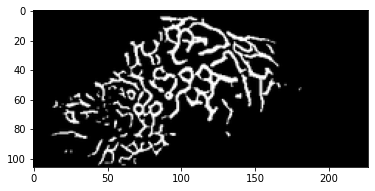

In [14]:
image, label = pattern_query_dataset[3]

print_heading("Input image")
plt.imshow(image)
plt.show()

## Apply tonemapping

## Segment and crop an image

## Extract pattern from an image

## Encode an image

In [16]:

encoded_sequence = encode_sequence_dataset(pattern_query_dataset, cfg, sequence_dataset=pattern_query_dataset)
print(len(encoded_sequence))
print("Encoded sequence")

  0%|                                                    | 0/12 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|███████████████████████████████████████████| 12/12 [00:14<00:00,  1.24s/it]


Calculating PCA
Getting encoding parameters...
Encoding...
3
Encoded sequence


In [69]:
encoded_sequence = encode_dataset(pattern_query_dataset, cfg)
print(len(encoded_sequence))
print("Encoded sequence")

  0%|                                                    | 0/12 [00:00<?, ?it/s]/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4066: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
/ekaterina/env/norppa/lib/python3.7/site-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "
100%|███████████████████████████████████████████| 12/12 [00:24<00:00,  2.07s/it]


Calculating PCA
Getting encoding parameters...
Encoding...
12
Encoded sequence


In [ ]:
# import pickle
# with open("encoded_2.pickle", 'wb') as f_file:
#     pickle.dump(encoded_sequence, f_file)


# with open("encoded.pickle", 'rb') as f_file:
#     encoded_sequence = pickle.load(f_file)

In [45]:
with open("patches.pickle", 'rb') as f_file:
    patches = pickle.load(f_file)

In [49]:
if cfg['codebooks'] is None:
    with open(cfg['codebooks_path'], "rb") as codebooks_file:
        cfg['codebooks'] = pickle.load(codebooks_file)
codebooks = cfg['codebooks']

In [ ]:
features, inds, labels, all_ells = patches

print(len(features))

## Create a small database for testing
This example uses a very simple database implemented as a Python class. The database might take a lot of space if all images are used, and in that case it is better to store it on a disc, e.g. with the help of SQL based database systems.

In [61]:

encoding_params = codebooks["gmm"]
features, inds, labels, all_ells = patches
features = apply_pca(features, codebooks["pca"])
features, patch_features = encode_all_images(features, inds, encoding_params)

encoded_sequence = (features, labels, patch_features, all_ells)

In [62]:
with open("encoded_ones.pickle", 'wb') as f_file:
    pickle.dump(encoded_sequence, f_file)

OverflowError: cannot serialize a bytes object larger than 4 GiB

In [17]:
db_database = DBDatabase("norppa", cfg)

# print(len(db_database.get_ids()))
# print(db_database.get_ids()[5])
# print(len(db_database.get_fisher_vectors()))
print(len(db_database.get_fisher_vectors_seq()))



57


## Perform re-identification

In [24]:
# encoded_sequence =  list(zip(list(zip(features, patch_features, all_ells)),labels))
result = identify_many(encoded_dataset, db_database, cfg)

# print(result)

NameError: name 'encoded_dataset' is not defined

In [19]:
db_seq_labels = np.array([[x['db_label'] for x in y[0]] for y in result])
print(db_seq_labels)
q_seq_labels = np.array(pattern_query_dataset.get_sequence_labels())
lns = pattern_query_dataset.get_sequence_lenghts()
db_labels = []
q_labels = []
for (i,ln) in enumerate(lns):
    q_label = q_seq_labels[i]
    db_label = db_seq_labels[i]
    q_label = [q_label] * ln
    q_labels = q_labels + q_label
    db_label = [db_label] * ln
    db_labels = db_labels + db_label
    
q_labels  = np.array(q_labels)
db_labels = np.array(db_labels)

topk = 5

hits = (db_labels.T == q_labels).T
print([sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(q_labels)
        for j in range(topk)])
        
    

[['phs021' 'phs010' 'phs149' 'phs082' 'phs137']
 ['phs021' 'phs116' 'phs082' 'phs115' 'phs001']
 ['phs137' 'phs088' 'phs022' 'phs170' 'phs010']]
[0.75, 0.75, 0.75, 0.75, 1.0]


In [74]:
db_labels = np.array([[x['db_label'] for x in y[0]] for y in result])
print(db_labels)
q_labels = np.array(pattern_query_dataset.get_labels())

print(len(q_labels))


topk = 5

hits = (db_labels.T == q_labels).T
print([sum((np.sum(hits[:, :j+1], axis=1) > 0)) / len(q_labels)
        for j in range(topk)])

[['phs010' 'phs044' 'phs082' 'phs176' 'phs088']
 ['phs010' 'phs034' 'phs044' 'phs061' 'phs082']
 ['phs010' 'phs170' 'phs137' 'phs116' 'phs082']
 ['phs021' 'phs167' 'phs101' 'phs087' 'phs038']
 ['phs021' 'phs115' 'phs082' 'phs061' 'phs097']
 ['phs021' 'phs021' 'phs130' 'phs051' 'phs130']
 ['phs021' 'phs021' 'phs188' 'phs045' 'phs151']
 ['phs021' 'phs023' 'phs051' 'phs149' 'phs100']
 ['phs021' 'phs174' 'phs023' 'phs021' 'phs109']
 ['phs091' 'phs096' 'phs213' 'phs149' 'phs115']
 ['phs021' 'phs087' 'phs149' 'phs149' 'phs188']
 ['phs021' 'phs021' 'phs101' 'phs097' 'phs176']]
12
[0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666, 0.9166666666666666]


In [100]:

hits = (db_seq_labels.T == q_seq_labels).T
q_seq_files = np.array(pattern_query_dataset.get_sequence_files())
not_found = q_seq_files[np.where(np.invert(np.any(hits, axis=1)))[0]]
print(len(not_found))

for path in sorted(not_found):
    sp = path.split('/')
    print(sp[6], " ", sp[7])
    

28
phs021   K38_Marjasaari_080611_phs021
phs022   K69_kaarmeluoto_230511_phs022
phs028   K23_Kaarmeluoto_120810_phs028
phs034   K1_Kanasaari_240610_phs034
phs081   K76A_Teni_karistaan_nimeton_250614_Phs081
phs087   K33_Iisalo_230514_Phs087
phs087   K53A_Iisalo020615_PHS087_X
phs087   K53A_Iisalo_300515_PHS087_X
phs100   45A_Iisalo_250515_Phs100
phs103   K13A_Kaarmesaari_290515_PHS103_X
phs103   K77_Kaarmesaari_090614_Phs103
phs109   7_Kaarmesaari_150617_Phs109
phs109   7_Kaarmesaari_300517_Phs109
phs114   K56A_Miessaarenluoto_010615_Phs114
phs114   K56A_Miessaarenluoto_120612_Phs114
phs114   K56A_Miessaarenluoto_220515_PHS114_X
phs116   53A_Heins_Kaukaanv_nimeton_140617_phs116
phs116   53A_Heins_Kaukaanv_nimeton_300517_Phs116
phs116   K26_Heins_Kaukaanvaaranv_270515_Phs116
phs125   79A_Vaaralahti_070617_Phs125_Phs303
phs125   K73A_Korkeas_kaukaanv_nimeton_140514_Phs125
phs160   K5_Laukkalan hevoss_210514_Phs160
phs160   K9_Laukkalan hevos_210514_Phs160
phs164   75A_Pitkasaari_21052017_

In [33]:
 get_topk_acc(labels, labels_db, indices, 5)

NameError: name 'get_topk_acc' is not defined

## Visualise re-identification results

In [ ]:
visualise_match(identification_result[0])
print()

## Apply full pipeline to another query image

In [ ]:
full_pipeline = [
            tonemap_step, 
            segment_step, crop_step,
            extract_pattern_step,
            curry(encode_pipeline, cfg=cfg),
            curry(identify_single, database=simple_db, cfg=cfg),
            visualise_match
            ]

apply_pipeline(*query_dataset[0], full_pipeline)
print()